In [2]:
operatorList = ["o1","o2","o3","o4","o5","o6","o7","o10","o11", "o12"]
sourceOperators = ["o1","o2", "o3", "o7"]
sinkOperators = ["o10","o11", "o12"]
sources = ["s1","s2", "s3"]

In [3]:
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
from matplotlib import pyplot as plt
import seaborn as sns

latencyBound = 0.000055


In [49]:
def createTable(path,operatorList):
    table = pd.read_csv(path)
    table["Real Time"] = ((table["Real Time"]-table["Real Time"].min())/1000)
    table = table.sort_values('Real Time')
    table.rename(columns={"Time":" - Time"},inplace=True)
    
    return [table[table["Operator"]==x].drop("Operator",axis=1).set_index("Real Time") for x in operatorList]

In [48]:
def drawAverageGraph(path,operatorList,eps,mode,withPrint=False):
    if withPrint:
        fig,axes= plt.subplots(1,2,figsize=(25,7))

    table = pd.read_csv(path)
    table["Real Time"] = ((table["Real Time"]-table["Real Time"].min())/1000)
    sortedTable = table.sort_values('Real Time')
    sortedTable.rename(columns={"Time":"Time"},inplace=True)
    timestamps = table["Real Time"].unique()
    
    
    opValues = {}
    # display processing time of the individual operators
    for i, operator in enumerate(operatorList):
        ox = table[table["Operator"]==operator].drop(columns=["Operator"]).groupby("Real Time").mean()
        start = ox.index[0]
        end = ox.index[-1]
        ox = ox.reindex(timestamps[(start < timestamps) & (timestamps < end)]).interpolate(method="linear").reindex(timestamps).rename(columns={"Time":operator})
        if withPrint:
            ox.plot(ax=axes[1])
        opValues[operator] = ox[operator]
        

    mean_series = pd.DataFrame(opValues).max(axis=1) 
    
    if withPrint:
       axes[1].axhline(y=latencyBound, color='pu rple', linestyle='--',label="Latency Bound")
       axes[1].set_ylabel("Measured Processing Time")
       axes[1].legend()
       mean_series.plot(ax=axes[0], label="Processing Time", color='green') 
       axes[0].axhline(y=latencyBound, color='purple', linestyle='--',label="Latency Bound")
       axes[0].set_ylabel("Measured Processing Time")
       axes[0].legend()
       axes[0].set_title("Maximum System Processing Time")
       axes[1].set_title("Processing Time across operators")
       fig.suptitle("Data for "+eps+" events per second - "+mode+" mode")
       plt.show()

    return mean_series

In [36]:
tables

[        Type           Time Operator                    Id
 0         11  1743966417450       o1                 1-2-4
 1         22  1743966417450       o2        12025050254402
 2         31  1743966417450       o3                0-6-10
 3         31  1743966417453       o3               8-16-23
 4         11  1743966417454       o1                7-6-11
 ...      ...            ...      ...                   ...
 187882    21  1743966612895       o2  199919-199917-199938
 187883    21  1743966612897       o2  199937-199932-199940
 187884    22  1743966612904       o2        12220511683679
 187885    22  1743966612907       o2        12220514594517
 187886    22  1743966612918       o2        12220525692523
 
 [187887 rows x 4 columns],
         Type           Time Operator                                   Id
 0         22  1743965096789       o2                       10704337970247
 1         11  1743965096791       o1                               0-1-13
 2         31  1743965096

In [ ]:
def plotCase(epsList,modesList):
    for i in epsList:
        #seriesList = {}
        plt.figure(figsize=(15,10))
        plt.axhline(y=latencyBound, color='purple', linestyle='--',label="Latency Bound")
        for j in modesList:
            # If j contains lowercase mode names but folders use capitalized names
            series = drawAverageGraph("Testing/deployment/" + j.capitalize() + "/Log-Summary-Times.csv", operatorList, i, j)
            series = series[series.index < 310]
            if(j=="variant"):
                j = "global"
            plt.plot(series.index,series.values,label=j+" mode")

        
        new_yticks = sorted(list(set(list(plt.yticks()[0]) + [latencyBound])))
        plt.yticks(new_yticks)
        #plt.title("Comparison of Maximum System Processing Times with "+i+" eps")
        plt.xlabel("Experiment runtime (s)",fontsize=20)
        plt.ylabel("Measured Processing Time (s)",fontsize=20)
        plt.legend(fontsize=20)
        plt.grid(color="lightgray",linestyle="--")
        plt.tight_layout()
        updated_ylabels = plt.gca().get_yticklabels()
        for label in updated_ylabels:
            text = label.get_text().replace('−', '-')  # Replace Unicode minus
            label.set_fontsize(18) 
            label.set_horizontalalignment("right")
            if float(text) == latencyBound:
                label.set_color('purple')
            else:
                label.set_rotation(20)
                
        updated_xlabels = plt.gca().get_xticklabels()
        for label in updated_xlabels:
            label.set_fontsize(18) 

        plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
        plt.savefig("my_graph"+i+".png", bbox_inches = 'tight', pad_inches = 0.1)
        plt.show()
            

In [45]:
tableH = pd.read_csv("Testing/deployment/Hybrid/Log-Summary-Times.csv")
tableL = pd.read_csv("Testing/deployment/Local/Log-Summary-Times.csv")
#tableN = pd.read_csv("normalLogs/Log-Summary.csv")
tableV = pd.read_csv("Testing/deployment/Variant/Log-Summary-Times.csv")
#tableP = pd.read_csv("perfectLogs/Log-Summary.csv")
tables = [tableV,tableL,tableH]


In [27]:
index = 0
names= ["variant","local","hybrid"]
sizes = {}
for table in tables:
    sizes[names[index]] = len(table[(table["Operator"]=="o10") | (table["Operator"]=="o11") | (table["Operator"]=="o12")])
    index += 1

recall = {}
for name in names:
    recall[name] = sizes[name]/sizes["local"]

In [28]:
data = {"Mode":["Global","Local","Hybrid"],
        "Recall":[recall["variant"],recall["local"],recall["hybrid"]]}
        

In [29]:
data

{'Mode': ['Global', 'Local', 'Hybrid'],
 'Recall': [4.645250114731528, 1.0, 7.177145479577788]}

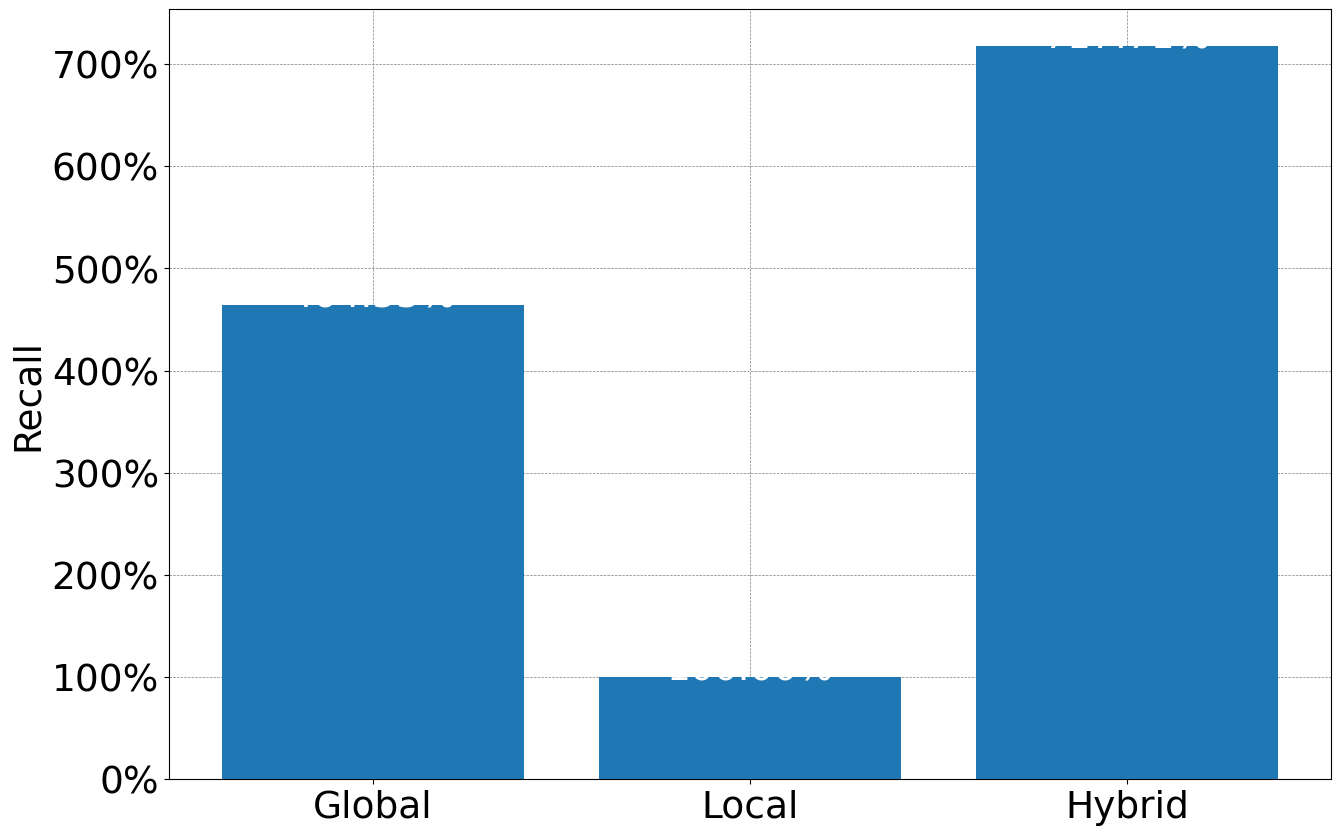

In [30]:
recallDf = pd.DataFrame(data)

plt.figure(figsize=(15, 10))

# Create the bar plot
bars = plt.bar(recallDf['Mode'], recallDf['Recall'],zorder=3)

plt.xlabel('Mode')
plt.ylabel('Recall')
#plt.title('Comparison of Recall',fontsize=40)

# Add numbers on top of the bars
for bar, value in zip(bars, sizes): #iterate through the bars object instead of a separate sizes object.
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height-0.1, f"{(sizes[value]/sizes['local'])*100:.2f}%", ha='center', va='bottom', fontsize=27, color='white',zorder=3)

# Format y-ticks as percentages
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.grid(True, linestyle='--', linewidth=0.5, color='gray',zorder=0)
plt.xlabel('')
plt.ylabel('Recall', fontsize=27)
plt.tick_params(axis='both', labelsize=27)
plt.savefig("recall.png",bbox_inches = 'tight', pad_inches = 0.1)

plt.show()

KeyError: 'Real Time'

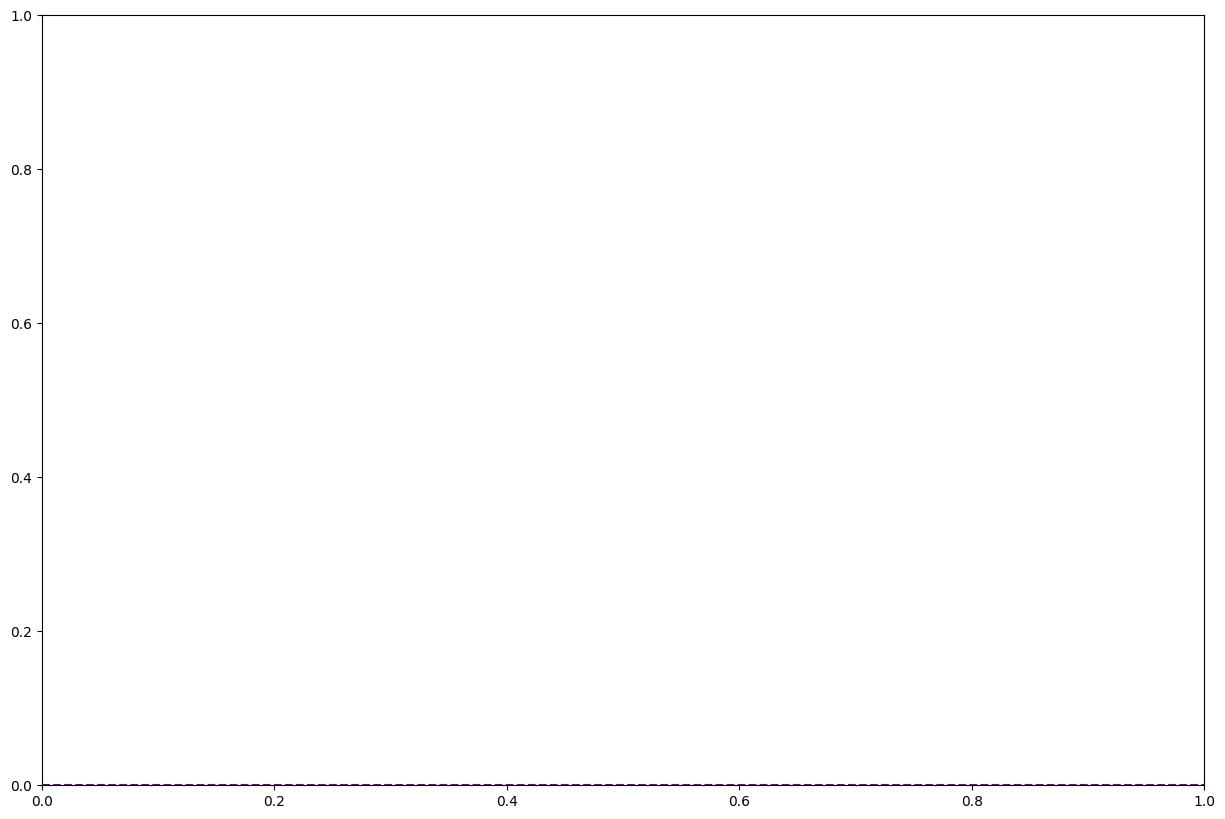

In [50]:
plotCase(".",["local","hybrid","variant"])